# Supervised Classification Urban Change Detection
This notebook is the complete workflow for urban change detection algorithm.
The goal of this process is to be able to identigfy pixels that have been urbanised (changed from vegetation to the built environment) during the operation of the LandSat Earth Observation Satellites (since 1987).

This notebook lets you:
- create training data to train the classifier on
- classify the data according to 4 broad landcover classes
- view the results of your classification process
- identify if and when a pixel that was previously not urban becomes dominantly urban (change detection)
- view the results of the change detection

The markdown cells have been designed to work with the 'Table Of Contents(2)' Jupyter notebook extension.
This is highly recommended, if you don't have it yet (and are working on the VDI on the 'agdc-py3-prod module'
select "Edit" on the menu bar above, click the "nbextension config" button at the bottom of the menu, and enable
the extension. The 'Collapsible Headings' extension is also highly recommended.

This was written Mike Barnes as part of his third graduate rotation, during January 2018.
Any questions, please contact me at michael.barnes@ga.gov.au

## Python Library Imports

In [2]:
%matplotlib notebook
import os

import numpy as np
import pandas as pd
import xarray as xr

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.colors as colors
import matplotlib.patches as mpatches

import gdal

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider, Dropdown
from IPython.display import display

from skimage import exposure
from scipy.signal import lfilter

import datetime

import warnings

import collections

## Functions for Loading Data and Building the Xarray
This project built on some existing work by Peter Tan. An output from Peter's urban change detection algorithm is raster files with all the relevant NBAR (analysis ready satellite derived surface reflectance readings) data saved to the output directory. To speed the loading and analysis during this script, this notebook will use those exisitng files if they are available. Otherwise it will load the data from the Digital Earth Australia archive.

### function: checkForLocalFiles

In [3]:
def checkForLocalFiles(study_area):
    rootdir = os.listdir('../')
    if study_area in rootdir:
        return True
    else:
        return False

### function: getData

In [4]:
def getData(study_area):
    # if the study area is a string, and is accessible locally, load it
    if isinstance(study_area, str):
        if checkForLocalFiles(study_area):
            data = getLocalData(study_area)
            return data
    # if the study area is a string and is on the list, load it
        else:
            data = DCLoadName(study_area)
    # if the study area is a list of coordinates, use them to load the data
    elif isinstance(study_area, list) and len(study_area) == 4:
        data = DCLoad(study_area)
        
    # if the study area isn't loaded locally, transfrom the DC originated xarray into "my" format  
    if not checkForLocalFiles(study_area):
        data = transformXarrayToCustomStyle(data)
        return data
    else:
        print('Data Loading Error')

### function: DCLoadName
This function is a wrapper for the DCLoad function, that allows previously used study areas to be easily restudied
by easily loading exactly the same area of interest (AOI).

In [90]:
def DCLoadName(study_area):   
    if study_area == 'mtbarker':
        lat_min = -35.05
        lat_max = -35.08
        lon_min = 138.85
        lon_max = 138.895  
    elif study_area == 'swmelb':
        lat_min = -37.879
        lat_max = -37.91
        lon_min = 144.705
        lon_max = 144.76  
    elif study_area == 'gunghalin':
        lat_min = -35.18
        lat_max = -35.21
        lon_min = 149.14
        lon_max = 149.17
    elif study_area == 'goldengrove': 
        lat_min = -34.77
        lat_max = -34.8
        lon_min = 138.66
        lon_max = 138.73
    elif study_area == 'molonglo':
        lat_min = -35.3
        lat_max = -35.33
        lon_min = 149.015
        lon_max = 149.06
    elif study_area == 'nperth':
        lat_min = -31.686
        lat_max = -31.73
        lon_min = 115.79
        lon_max = 115.813
    elif study_area == 'swbris':
        lat_min = -27.66
        lat_max = -27.7 
        lon_min = 152.877
        lon_max = 152.93
    elif study_area == 'swsyd':
        lat_min = -33.993
        lat_max = -34.04
        lon_min = 150.715 
        lon_max = 150.78
    elif study_area == 'goolwa':
        lat_min = -35.49
        lat_max = -35.522
        lon_min = 138.761
        lon_max = 138.83
    elif study_area == 'gladstone':
        lat_min = -23.868
        lat_max = -23.903
        lon_min = 152.22
        lon_max = 152.265
    elif study_area == 'goldcoast':
        lat_min = -28.08
        lat_max = -28.125
        lon_min = 153.360
        lon_max = 153.4
    elif study_area == 'newcastle':
        lat_min = -32.895
        lat_max = -32.918
        lon_min = 151.59
        lon_max = 151.62
    
    return DCLoad([lat_min, lat_max, lon_min, lon_max])

### function: DCLoad
This function is a variation of a datacube query supplied by Erin Telfer.

In [6]:
def DCLoad(study_area):
    # to time how long the load takes
    start = datetime.datetime.now()
    print('Loading data') 
    print('Load Started At: ' + str(start))
    
    # define temporal range 
    start_of_epoch = '1987-01-01'
    end_of_epoch =  '2017-10-31'

    # define bands of interest
    bands_of_interest = ['blue', 'green', 'red', 
                         'nir', 'swir1', 'swir2']

    # Landsat sensors of interest are defined
    sensors = ['ls8', 'ls7', 'ls5'] 

    # unpack input parameter
    lat_min, lat_max, lon_min, lon_max = study_area    

    print('Bounding box: ' + str(lat_min) + ' S, ' + str(lon_min) +
          ' E to ' + str(lat_max) + ' S, ' + str(lon_max) + ' E' )
    print('Epoch: ' + start_of_epoch + ' to ' + end_of_epoch)
    print('Sensors: ' + str(sensors))
    print('Bands of Interest: ' + str(bands_of_interest))

    # create query
    query = {'time': (start_of_epoch, end_of_epoch),}
    query['x'] = (lon_min, lon_max)
    query['y'] = (lat_max, lat_min)
    query['crs'] = 'EPSG:4326'

    #Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.
    # It should be noted the "land_sea" code will remove all ocean/sea pixels.
    mask_components = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True,
    'land_sea': 'land'}

    # Connect to DataCube
    dc = datacube.Datacube(app='Urban Change Detection')
    
    # Data for each Landsat sensor is retrieved and saved in a dict for concatenation
    sensor_clean = {}
    
    for sensor in sensors:
        # Load the NBAR and corresponding PQ
        sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                              measurements = bands_of_interest,  **query)
        sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                            fuse_func=ga_pq_fuser, **query)

        # Retrieve the projection information before masking/sorting
        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine        

        # Combing the pq so it is a single 
        sensor_all = xr.auto_combine([sensor_pq,sensor_nbar])
        sensor_clean[sensor] = sensor_all

        print('Loaded %s' % sensor) 

    print('Concatenating')
    nbar_clean = xr.concat(sensor_clean.values(), 'time')
    nbar_clean = nbar_clean.sortby('time')
    nbar_clean.attrs['crs'] = crs
    nbar_clean.attrs['affin|e'] = affine    

    print ('Load and Xarray build complete')
    print('Process took ' + str(datetime.datetime.now() - start))
    
    # return xarray
    return nbar_clean

### function: getLocalData

In [7]:
def getLocalData(study_area):
    """A quick helper function to load the output files from Peter's code for the given location.
    It returns and Xarray of the landsat data for that study area."""
    # build a list of all files in the directory (ie the folder for that location)
    location = '../' + study_area + '/'
    files = os.listdir(location)

    print('Loading data from: ' + location)
    
    # build a list of all the NBAR*.img file names and which bands they represent
    NBARfiles = []
    bands = []
    for file in files:
        if file[-4::] == '.img' and file[0:4] == 'NBAR':
            NBARfiles.append(file)
            bands.append(file.split('NBAR_')[1].split('.img')[0])

    # open all the .img files with NBAR in the name, convert to numpy array, swap axes so order is (x, y, t)
    # and save to dict
    raw_data = {}
    for i in range(len(NBARfiles)):
        raw_data[bands[i]] = gdal.Open(location + NBARfiles[i]).ReadAsArray().swapaxes(0,2)
#     num_scenes = len(raw_data['red'][0][0])   # delete this?

    # build a list of all the dates represented by each band in the NBAR files
    # reuse the list of NBAR file names, but this time access the .hdr file
    in_dates = False
    dates = []
    for line in open(location + NBARfiles[0].split('.img')[0] + '.hdr'):
        if line[0] == '}':
            continue
        if in_dates:
            dates.append(line.split(',')[0].strip())
        if line[0:10] == 'band names':
            in_dates = True

    # save list of satellite originated bands
    sat_bands = bands.copy()

    # add the yet to be calculated derivative bands to the overall bands list
    bands += ['cloud_mask']

    # building the Xarray
    # define the size for the numpy array that will hold all the data for conversion into XArray
    x = len(raw_data['red'])
    y = len(raw_data['red'][0])
    t = len(raw_data['red'][0][0])
    n = len(bands)

    # create an empty numpy array of the correct size
    alldata = np.zeros((x, y, t, n), dtype=np.float32)

    # populate the numpy array with the satellite data
    # turn all no data NBAR values to NaNs
    for i in range(len(sat_bands)):
        alldata[:,:,:,i] = raw_data[sat_bands[i]]
        alldata[:,:,:,i][alldata[:,:,:,i] == -999] = np.nan

    # convert the numpy array into an xarray, with appropriate lables, and axes names
    data = xr.DataArray(alldata, coords = {'x':range(x), 'y':range(y), 'date':dates, 'band':bands},
                 dims=['x', 'y', 'date', 'band'])
    
    # import cloudmask and add to xarray
    cloudmask = gdal.Open(location + '/tsmask.img').ReadAsArray().swapaxes(0,2)
    data.loc[:,:,:,'cloud_mask'] = cloudmask
    
    return data

### function: transformXarrayToCustomStyle

In [8]:
def transformXarrayToCustomStyle(data_new):
    # downscale the dataset to the dataarray, and transpose so the variable numbers are right
    datafixed = data_new.to_array().transpose('x','y','time','variable')
    
    # rename the variables into 'band'
    datafixed = datafixed.rename({'variable':'band',})
    
    # pull out the current list of bands, find the index number of "pixelquality"
    # replace with 'cloud_mask', and reassign
    new_bands = list(datafixed.band.values)
    cm = new_bands.index('pixelquality')
    new_bands[cm] = 'cloud_mask'
    datafixed.band.values = new_bands
    
    # change pixel quality values to mask, 0 = good, 3 = bad
    cm_vals = data[:,:,:].sel(band='cloud_mask').values
    cm_vals[cm_vals == 0] = 1
    cm_vals[cm_vals == 16383] = 0
    cm_vals[cm_vals != 0] = 3
    
    return datafixed

### function: customStyleXarrayToStandard

In [9]:
def customStyleXarrayToStandard(data):
    return data.to_dataset(dim='band')

## Other broad scope variables

In [67]:
# easier to work with integers than strings, so map the planned training classes to integers
landcover = {'vegetation':1,'urban':2,'earth':3,'water':4}
# range of pretermined study areas to use as sources for training data
study_areas = ['mtbarker', 'swmelb', 'gunghalin', 'goldengrove', 'molonglo', 'nperth', 'swbris', 'swsyd',
               'goolwa','gladstone','goldcoast','newcastle']

# not in broad scope yet
sat_bands = ['blue','green','red','nir','swir1','swir2']
dc_bands = sat_bands.copy() + ['cloud_mask']

colours = ['r', 'b', 'm', 'c']

# Viewing the Change Detection Results

## drawAnalysedScene()

In [12]:
def drawAnalysedScene(data, scene_num, alpha, change_grid):
    
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    t = data.shape[2]
    
    if scene_num > (t -1):
        scene_num = t - 1
    RGB = ['R','G','B']
    date = str(data[:,:,scene_num].date.values)
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + date + ', over ' + study_area)
    
    # define the current colour map to display the change results raster properly
    current_cmap = matplotlib.cm.get_cmap('Reds_r')
    current_cmap.set_under('k', alpha=0.0)
    current_cmap.set_over('r', alpha=1.0)
    current_cmap.set_bad('k', alpha=0.0)  
    
    # draw the change detection results mask
    ax.imshow(change_grid, alpha = alpha, interpolation='none', cmap = current_cmap, clim = [0.5, 0.6])
    return ax

## drawAnalysedPlots()

In [24]:
def drawAnalysedPlots(data, top_scene_num, left_alpha, left_change_grid,
                      bottom_scene_num, right_alpha, right_change_grid):
    
    ax1 = plt.subplot2grid([2,2],[0,0], rowspan = 1, colspan = 1)
    ax1.clear()
    ax1 = drawAnalysedScene(data, top_scene_num, left_alpha, left_change_grid)

    ax2 = plt.subplot2grid([2,2],[0,1], rowspan = 1, colspan = 1)
    ax2.clear()
    ax2 = drawAnalysedScene(data, top_scene_num, right_alpha, right_change_grid)
    
    ax3 = plt.subplot2grid([2,2],[1,0], rowspan = 1, colspan = 1)
    ax3.clear()
    ax3 = drawAnalysedScene(data, bottom_scene_num, left_alpha, left_change_grid)

    ax4 = plt.subplot2grid([2,2],[1,1], rowspan = 1, colspan = 1)
    ax4.clear()
    ax4 = drawAnalysedScene(data, bottom_scene_num, right_alpha, right_change_grid)    
    
    
    plt.draw()

## function: results

In [135]:
def results(data, top_scene_num, left_alpha, left_change_grid,
                      bottom_scene_num, right_alpha, right_change_grid):
 
    # control the figure size
    fig = plt.figure(figsize=[10,10])
    plt.tight_layout()
#     axs = fig.axes
#     plt.subplots_adjust(hspace = 0.6)
    
    # draw the figure
    drawAnalysedPlots(data, top_scene_num, left_alpha, left_change_grid,
                      bottom_scene_num, right_alpha, right_change_grid)

## Open Existing Change Results

In [83]:
study_area_dd = Dropdown(options=study_areas, value = study_areas[0], description='Study Area', disabled = False)
display(study_area_dd)

Dropdown(description='Study Area', options=('mtbarker', 'swmelb', 'gunghalin', 'goldengrove', 'molonglo', 'nperth', 'swbris', 'swsyd', 'goolwa', 'gladstone', 'goldcoast', 'newcastle'), value='mtbarker')

In [143]:
# work with the value of the dropdown list
study_area = study_area_dd.value

files = os.listdir('../' + study_area + '/')
pklfiles = []
for file in files:
    if file[-3::] == 'pkl':
        pklfiles.append(file)
        print(file)
if len(pklfiles) == 1:
    res_file = pklfiles[0]
else:
    print('Which results file would you like to open?')
    res_file = input('\nEnter copy and paste filename here: ')
print('')
data = getData(study_area)

print('Study area data loaded.')

left_change = gdal.Open('../' + study_area + '/change_time.img').ReadAsArray()
left_change[left_change == 0] = np.nan
left_change_mask = left_change.copy()
left_change_mask[np.isfinite(left_change_mask)] = 1

results_save_location = '../' + study_area + '/' + res_file
right_change = np.load(results_save_location)
right_change_mask = right_change.copy()
right_change_mask[np.isfinite(right_change_mask)] = 1

num_scenes = data.shape[2]

changeresults_svc_finalRun.pkl

Loading data from: ../newcastle/
Study area data loaded.


## Draw Results Analysis Plots

In [144]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interact(results,
             data = fixed(data),
             top_scene_num = IntSlider(value = 1, min = 0, max = num_scenes -1 ,description = "Scene Number"),
             left_alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Left Alpha"),
             left_change_grid = fixed(left_change_mask),
             bottom_scene_num = IntSlider(value = num_scenes - 1, min = 0, max = num_scenes - 1,description = "Scene Number"),
             right_alpha= FloatSlider(value = 0.6, min = 0, max = 1, description = "Right Alpha"),
             right_change_grid = fixed(right_change_mask))

interactive(children=(IntSlider(value=1, description='Scene Number', max=697), FloatSlider(value=0.6, description='Left Alpha', max=1.0), IntSlider(value=697, description='Scene Number', max=697), FloatSlider(value=0.6, description='Right Alpha', max=1.0), Output()), _dom_classes=('widget-interact',))

In [145]:
changediff = left_change - right_change
print('Peter\'s pixel change proportion: ' +
      str(round(100* (left_change[np.isfinite(left_change)].size / left_change.size),2)) + ' %')
print('Peter\'s pixel change proportion: ' +
      str(round(100* (right_change[np.isfinite(right_change)].size / right_change.size),2)) + ' %')
print('Total Proportion commonly detected as change: ' +
      str(round(100* (right_change_mask[(left_change_mask == 1) & (right_change_mask == 1)].size / right_change.size),2)) + ' %')
print("Mean Difference: " + str(np.nanmean(changediff)))
print("Min Difference: " + str(np.nanmin(changediff)))
print("Max Difference: " + str(np.nanmax(changediff)))
print("Standard Deviation: " + str(np.nanstd(changediff)))

Peter's pixel change proportion: 12.66 %
Peter's pixel change proportion: 35.58 %
Total Proportion commonly detected as change: 10.16 %
Mean Difference: -0.191091
Min Difference: -25.0
Max Difference: 24.0
Standard Deviation: 2.72864


In [ ]:
# % matplotlib inline
# imshow(changediff)
# plt.colorbar()

In [109]:
left_change_mask & right_change_mask

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [114]:
right_change_mask[(left_change_mask == 1) & (right_change_mask == 1)].size

1468

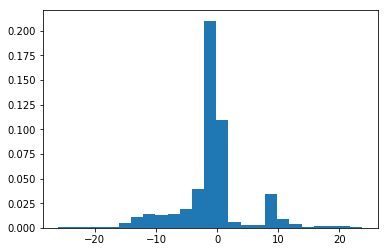

In [126]:
plt.hist(changediff[np.isfinite(changediff)].flatten(), 25, density=True)
plt.show()

In [ ]:
right_change_mask[(left_change_mask == 1) & (right_change_mask == 1)]

In [ ]:
l = left_change[np.isfinite(left_change) & ~np.isfinite(right_change_mask)]
r = right_change[np.isfinite(right_change)].flatten()
b = right_change[(left_change_mask == 1) & (right_change_mask == 1)]